In [1]:
from torchpgm.data import *
from torchpgm.utils import *
from torchpgm.standardize import *

from torchpgm.layers import *
from torchpgm.subedge import *
from torchpgm.edge import *
from torchpgm.model import *

device = "cuda"

batch_size = 100 
Nh = 50 ## Number of hidden units
n_epochs = 40000 ## For training

l1b = 2500 ## Strength of l1b regularization
l2 = 1000 ## Strength of l2 regularization on visible units bias
lr = 0.0001 ## learning rate

model_full_name = f"example"

#standardize_fasta(folder, file)

## Data

In [2]:
folder = "data/example"
file = f"{folder}/test.fasta"

It's possible to use directly a fasta file as a dataset (mostly with a pretrained model) but not comfortable

In [3]:
dataset = FastaDataset(file)

It's more comfortable to use a standardize data file that can be build directly from a FASTA file. `standardize_fasta` can be used to convert the FASTA file into a One Hot encoded tensor containing all aligned sequences. Once done it will clusterize sequences by identity (MMSEQS is required) and split according to these clusters between training and validation set

In [ ]:
standardize_fasta(folder, file)

Once done you can use and reuse the generated `data.pt` file to load the different sets 

In [5]:
train_dataset = StandardDataset(f"{folder}/data.pt", subset = "train")
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

val_dataset = StandardDataset(f"{folder}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

full_set = StandardDataset(f"{folder}/data.pt")
full_loader = DataLoader(full_set, batch_size = batch_size, shuffle = False)

Available :  x L cluster_index weights subset
Available :  x L cluster_index weights subset
Available :  x L cluster_index weights subset


## Model

To improve modularity we hierarchically organized the models :
- The main class is the Markov Random Field (`torchpgm.model.AbstractMRF`) that organize different operations : Gibbs sampling, probability computation, AIS, training ...
- Since the MRF is abstract it must be implemented by a child class, for now only one is available (`torchpgm.model.RBM`)

The main class relies on two types of classes :
- The layers deriving from `torchpgm.layers.AbstractLayer` in charge of sampling a layer from a potential, storing the bias of the layers, gauges and regularization specific to a layer. Three are available : `torchpgm.layers.OneHotLayer` (for sequences) and `torchpgm.layers.GaussianLayer`, `torchpgm.layers.DReLULayer` for hidden layers.
- The edges and subedges deriving from `torchpgm.edge.AbstractEdge` and `torchpgm.subedge.AbstractSubEdge` an edge is for modularity reasons a list of subedges that handle the cross operation between layers mostly : computation of cross term in the energy, update of weights, etc. Three types of edges are availables : the standard one `torchpgm.edge.DenseEdge`, the convolution `torchpgm.edge.ConvolutionalEdge` and the filterbank `torchpgm.edge.FilterbankEdge` (basically a convolution with no shared weights)

As a starting point we can compute an initial potential for the visible units such like that

In [8]:
q, N = train_dataset[0][0].size()

g = torch.zeros(q, N)
for x, _, w, _ in train_dataset:
    g += w*x
g = np.log(1+g)
W = sum(train_dataset.weights)
g = (g - g.mean(0)[None]).flatten()/W

Then we build the two layers the visible one with random or not random potentials and the hidden one

In [9]:
v = OneHotLayer(None, N=N, q=q, name="v")
v = OneHotLayer(g, N=N, q=q, name="v")
h = GaussianLayer(N=Nh, name="h")

We build the edge also to connect the two

In [10]:
edge = DenseEdge(v,h)

/home/malbranke/torchpgm-standalone/torchpgm/subedge.py:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.weight)


And the RBM whch is of the form `RBM(visible, hidden, edge)`

2022-02-28 18:10:38.140324: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-02-28 18:10:38.140355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


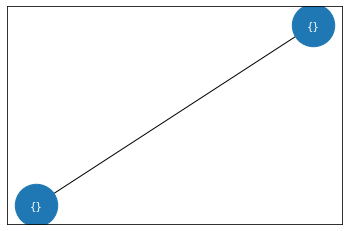

In [11]:
model_rbm = RBM(v,h,edge,path=folder)

Then for training we need the optimizer. We can put the RBM on GPU and do a first AIS (not working well...)

In [12]:
optimizer = optim.AdamW(model_rbm.parameters(), lr=lr)
model_rbm = model_rbm.to(device)
model_rbm.ais()

3.0480058193206787

## Training

Training is straightforward. Every 30 epochs the model will be save in `folder/weights`, make sure to create this directory before running the model.

In [ ]:
for epoch in range(1, n_epochs):
    model_rbm.train_epoch(optimizer, train_loader, train_dataset, 
                          regularizer = {"l1b" : l1b, "l2": l2}, 
                          epoch = epoch, savepath=f"{folder}/weights/{model_full_name}")
    shuffle(train_dataset.x_m)

    if not epoch % 10:
        model_rbm.ais()
        model_rbm.val(val_loader, epoch)

## Validation

Now we load an epoch we liked

In [14]:
best_epoch = 120
model_rbm.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")

We go into evaluation mode

In [15]:
model_rbm.eval()
model_rbm.ais()

3.0459482669830322

On training set

In [16]:
model_rbm.val(train_loader, 0)

Val Epoch: 0 [100%] || Time: 0 min 4 || P(v): -0.124 || P(v,h): -0.157 || Rec: 0.712


On validation set

In [17]:
model_rbm.val(val_loader, 0)

Val Epoch: 0 [100%] || Time: 0 min 4 || P(v): -0.349 || P(v,h): -0.383 || Rec: 0.689
